In [1]:
# Install required packages 
!pip install pysptools
!pip install multiprocess
!pip install cvxopt
!pip install --upgrade seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:

"""
Implementation of Linear Spectral Unmixing Analysis (LSMA) for fractional roof material type

"""

import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import pysptools.util as sp_utils
import pysptools.noise as noise
import pysptools.abundance_maps as amap
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocess as mp
import cvxopt
import random
from osgeo import gdal
from osgeo import osr
from osgeo import gdal_array
from functools import partial
from functools import reduce

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Completed ...")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/code/aws
Completed ...


In [26]:

"""
Supporting functions for the OPP rooftop materials mapping project

List of functions:

'array_to_tif': convert a numpy array to a GeoTIFF with spatial dimensions of a reference image
'pixel_to_xy': convert pixel to lat/long coordinates
'mnf_transform': generate N components of a Minimum Noise Fraction (MNF) transformation on an image array
'ravel_and_filter': converts a numpy array (m,n,p) to ((m*n), p)
'lsma': simple Linear Spectral Mixture Analysis (LSMA)
'mesma': extention of LSMA to handle multiple endmembers
'partition': split an array into chunks for multiprocessing work

"""


#############
# Functions #
#############


def array_to_tif(arr, ref, out_path, clip=False, shp=None):
    """
    Generate a xarray DataArray with spatial information
    Match dimensions to a reference image
    """
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=1,
                          dtype='float32', driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr


# Function to sample raster values to points for multi-band image
def img_vals_at_pts(img, points):
    # Extract x and y coordinates from the points
    x_coords = points["geometry"].x.values.astype(int)
    y_coords = points["geometry"].y.values.astype(int)
    # Ensure coordinates are within the image bounds
    x_coords = np.clip(x_coords, 0, img.shape[2] - 1)
    y_coords = np.clip(y_coords, 0, img.shape[1] - 1)
    # Sample the values at the specified points
    sampled_values = img[:, y_coords, x_coords]
    return np.asarray(sampled_values)



def mnf_transform(data_arr,n_components=5,nodata=-9999):
    """
        Applies the MNF rotation to a raster array; returns in HSI form
        (m x n x p). Arguments:
            rast    A NumPy raster array
            nodata  The NoData value
    """
    arr = data_arr.copy().transpose()
    arr[arr == nodata] = 0  # Remap any lingering NoData values
    # Apply the Minimum Noise Fraction (MNF) rotation
    mnf = noise.MNF()
    mnf_arr = mnf.apply(arr)
    if n_components is not None:
        return mnf_arr  # return the entire array
    else:
        print(f"Returning {n_components} components ...")
        return mnf_arr.get_components(n_components)  # return n components


def ravel_and_filter(arr, cleanup=True, nodata=-9999):
    """
    Reshapes a (p, m, n) array to ((m*n), p) where p is the number of
    dimensions and, optionally, filters out the NoData values. Assumes the
    first axis is the shortest. Arguments:
        arr      A NumPy array with shape (p, m, n)
        cleanup  True to filter out NoData values (otherwise, only ravels)
        nodata   The NoData value; only used in filtering
    """
    shp = arr.shape
    # If the array has already been raveled
    if len(shp) == 1 and cleanup:
        return arr[arr != nodata]
    # If a "single-band" image
    if len(shp) == 2:
        arr = arr.reshape(1, shp[-2]*shp[-1]).swapaxes(0, 1)
        if cleanup:
            return arr[arr != nodata]
    # For multi-band images
    else:
        arr = arr.reshape(shp[0], shp[1]*shp[2]).swapaxes(0, 1)
        if cleanup:
            return arr[arr[:,0] != nodata]
    return arr


# Implementation of the Fully Constrained Least Squares (FCLS)
def lsma_(cases, members):
    # For regular LSMA with single endmember spectra
    am = amap.FCLS()
    # c is number of pixels, k is number of bands
    cc, kk = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    print(f"c: {cc}; k: {kk}")
    return am.map(cases.reshape((1, cc, kk)), members, normalize=False)


# Adjustment to handle multiple endmembers
def mesma_(array_pairs):
    am = amap.FCLS()
    # For multiple endmember spectra, in chunks
    cases, endmembers = array_pairs
    # c is number of pixels, k is number of bands
    c, k = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    return [
        am.map(
            cases[i,...].reshape((1, 1, k)), 
            endmembers[i,...],
            normalize = False) for i in range(0, c)
    ]
    

def partition(array, processes, axis=0):
    """
    Creates index ranges for partitioning an array to work on over multiple
    processes. Arguments:
        array           The 2-dimensional array to partition
        processes       The number of processes desired
    """
    N = array.shape[axis]
    P = (processes + 1)  # Number of breaks (number of partitions + 1)
    # Break up the indices into (roughly) equal parts
    partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
                          np.linspace(0, N, P, dtype=int)[1:]))
    # Final range of indices should end +1 past last index for completeness
    work_indices = partitions[:-1]
    work_indices.append((partitions[-1][0], partitions[-1][1] + 1))
    return work_indices


print("Functions imported ...")

Functions imported ...


In [35]:
class PPI(object):
    """
    Performs the pixel purity index algorithm for endmembers finding.
    """

    def __init__(self):
        self.E = None
        self.w = None
        self.idx = None
        self.idx3D = None
        self.is_normalized = False

    def extract(self, M, q, numSkewers=10000, normalize=False, mask=None):
        """
        Extract the endmembers.

        Parameters:
            M: `numpy array`
                A HSI cube (m x n x p).

            q: `int`
                Number of endmembers to find.

            numSkewers: `int [default 10000]`
                Number of "skewer" vectors to project data onto.
                In general, recommendation from the literature is 10000 skewers.

            mask: `numpy array [default None]`
                A binary mask, when *True* the corresponding signal is part of the
                endmembers search.

        Returns: `numpy array`
                Recovered endmembers (N x p).
        """
        if normalize == True:
            M = _normalize(M)
            self.is_normalized = True
        h, w, numBands = M.shape
        self.h, self.w, self.numBands = M.shape
        self.q = q
        M = np.reshape(M, (self.w*h, M.shape[2]))

        if isinstance(mask, np.ndarray):
            m = np.reshape(mask, (self.w*h))
            cM = _compress(M, m)
        else:
            cM = M

        self.E, self.idx = eea.PPI(cM, q, numSkewers)
        self.idx3D = [(i % self.w, i // self.w) for i in self.idx]
        return self.E

    def __str__(self):
        return 'pysptools.eea.eea_int.PPI object, hcube: {0}x{1}x{2}, n endmembers: {3}'.format(self.h, self.w, self.numBands, self.q)

    def get_idx(self):
        """
        Returns: `numpy array`
            Array of indices into the HSI cube corresponding to the
            induced endmembers
        """
        return self.idx3D

    def plot(self, path, axes=None, suffix=None):
        _plot_end_members(path, self.E, 'PPI', self.is_normalized, axes=axes, suffix=suffix)

    def display(self, axes=None, suffix=None):
        _display_end_members(self.E, 'PPI', self.is_normalized, axes=axes, suffix=suffix)
        

class AdaptedPPI(PPI):
    def extract_per_class(self, ref_data, labels, q, num_skewers=10000, normalize=False):
        """
        Extract the endmembers per class.

        Parameters:
            ref_data: `numpy array`
                A reference data array (n x p), where n is the number of samples
                and p is the number of bands.
                
            labels: `numpy array`
                A 1D array of class labels corresponding to the samples in ref_data.

            q: `int`
                Number of endmembers to find per class.

            numSkewers: `int [default 10000]`
                Number of "skewer" vectors to project data onto.

            normalize: `bool [default False]`
                If True, the method will normalize the data.
        """
        classes = np.unique(labels)
        class_endmembers = {}

        for cls in classes:
            # Extract the data for the current class
            class_data = ref_data[labels == cls]

            # Reshape if necessary and apply PPI
            h, w = class_data.shape
            class_data_reshaped = np.reshape(class_data, (w*h, -1))
            
            # Use the existing extract method on the subset
            self.extract(class_data_reshaped, q, numSkewers=num_skewers, normalize=normalize)
            
            # Store the extracted endmembers
            class_endmembers[cls] = self.E

        return class_endmembers
    

['class_code' 'uid' 'ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg' 'mnf1' 'mnf2']


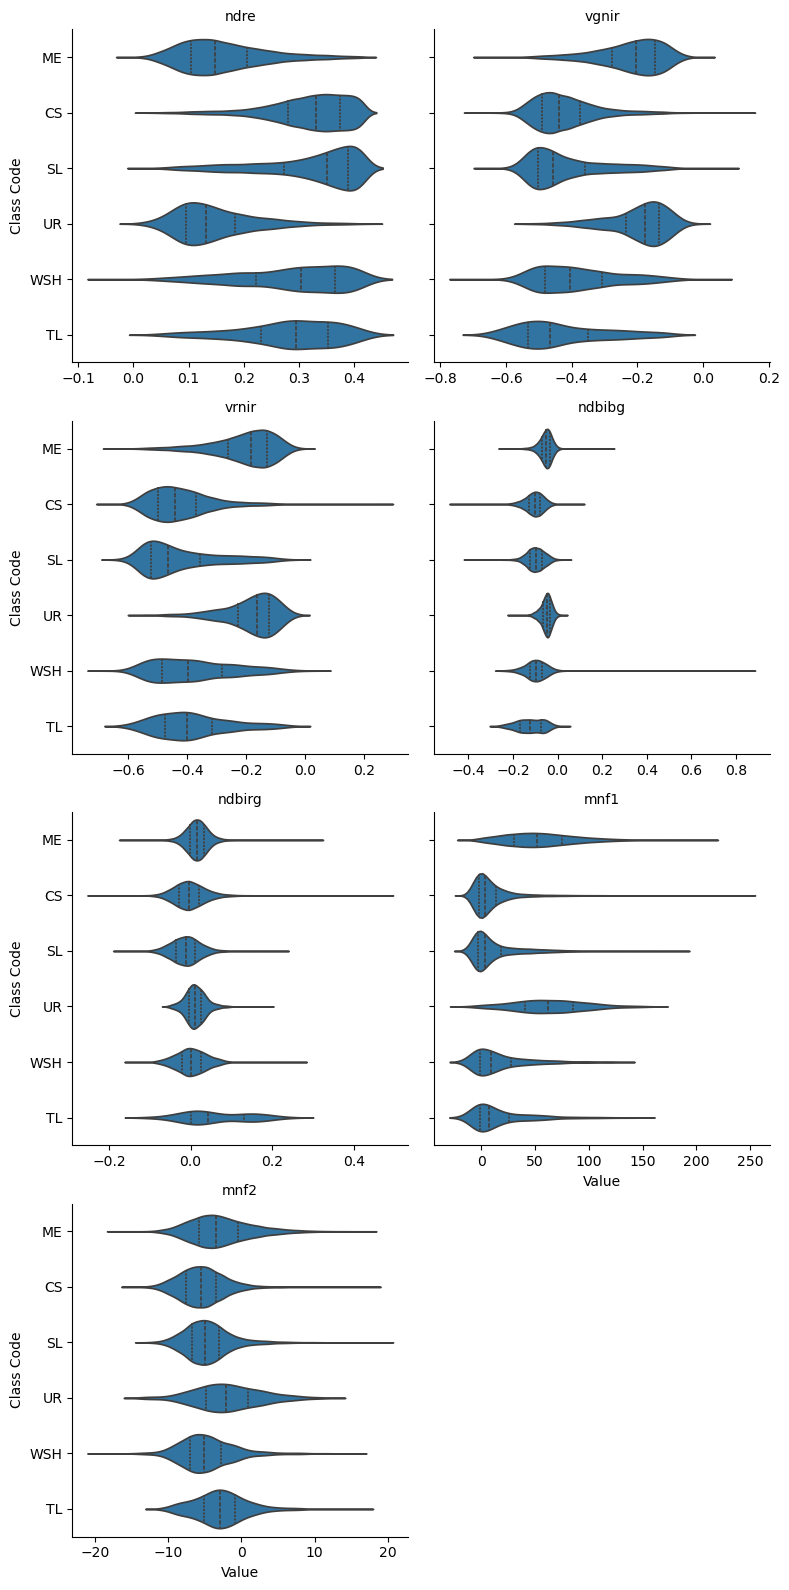

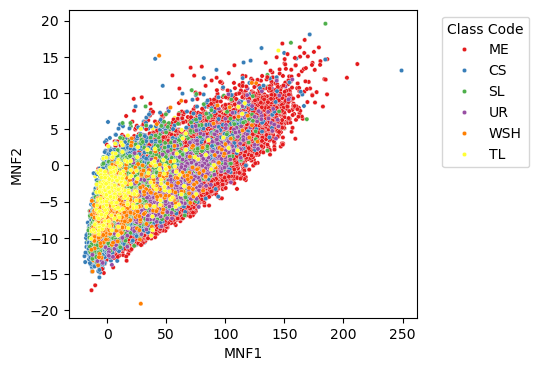

['ME' 'CS' 'SL' 'UR' 'WSH' 'TL']


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#######################################
# Load the spectral library data      #
# Filter out likely vegetated samples #
#######################################

# Read in the sampled potential endmembers data frame
ref_sp = pd.read_csv("dc_data_reference_sampled_mnf.csv")
ref_sp = ref_sp[ref_sp['ndre'] < 0.42]  # filter out high NDRE values (vegetation)
# Select the needed columns
ref_sp = ref_sp[['class_code','uid','ndre','vgnir','vrnir','ndbibg','ndbirg','mnf1','mnf2']]
ref_sp['class_code'] = ref_sp['class_code'].astype(str)
print(ref_sp.columns.values)

# Merge the Wood Shingle (WS) and Shingle (SH) classes
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref_sp['class_code'].replace(merge, inplace=True)
ref_sp['class_code'].value_counts()  # check the counts again


#########################################
# Plots and mean/median endmember array #
#########################################

# Create horizontal violin plot facet grid

# Melt the DataFrame to long format
ref_sp_m = ref_sp.melt(
    id_vars=['class_code'],
    value_vars=['ndre','vgnir','vrnir','ndbibg','ndbirg','mnf1','mnf2'],
    var_name='Band',
    value_name='Value')

# Create a facet plot
g = sns.catplot(data=ref_sp_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', col_wrap=2, height=4)

# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")
# Display the plot
plt.show()

# Create a scatter plot with MNF1 and MNF2, colored by class code
plt.figure(figsize=(4.5, 4))
sns.scatterplot(x='mnf1', y='mnf2', hue='class_code', data=ref_sp, palette='Set1', s=10)
plt.xlabel('MNF1')
plt.ylabel('MNF2')
plt.legend(title='Class Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create an array of the class means
print(ref_sp['class_code'].unique())

# Create a mean and median MNF library np array by material type

class_codes = ref_sp['class_code'].unique()

Shape: (7, 7555, 6046); 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 7)>
array([1, 2, 3, 4, 5, 6, 7])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
    spatial_ref  int64 0; 
Band Names: ('ndre', 'vgnir', 'vrnir', 'ndbibg', 'ndbirg', 'mnf1', 'mnf2'); 
Data Type: float64


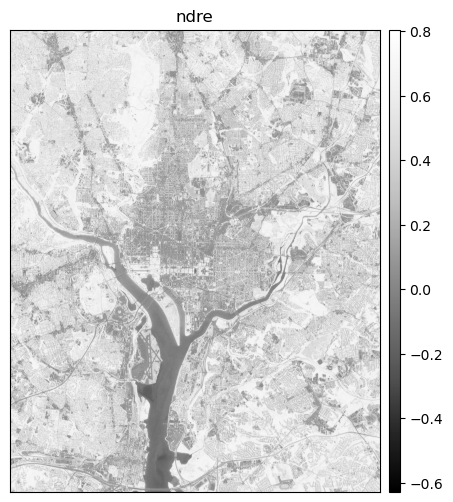

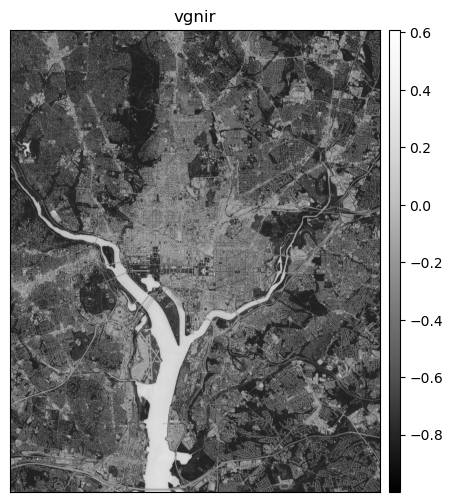

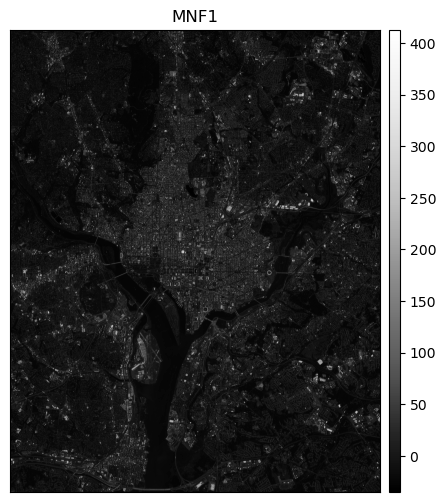

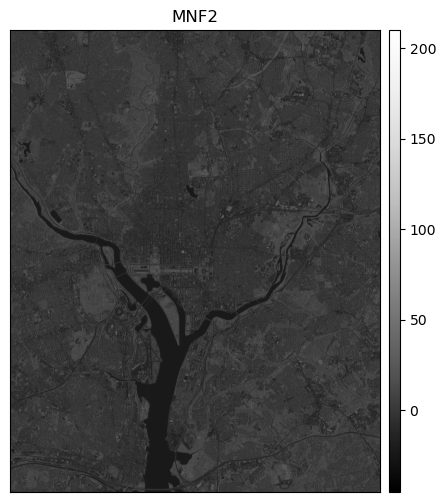

<Axes: title={'center': 'MNF2'}>

In [15]:
# Bring in the image file and get the projection information
mnf_path = "dc_data_psscene13b_mnf_ind.tif"
stack_mnf = rxr.open_rasterio(mnf_path)
print(
    f"Shape: {stack_mnf.shape}; \n"
    f"NoData Value: {stack_mnf.rio.nodata}; \n"
    f"Bands: {stack_mnf.band}; \n"
    f"Band Names: {stack_mnf.long_name}; \n"
    f"Data Type: {stack_mnf[0].dtype}")
# Plot one image as an example (green band)
ep.plot_bands(stack_mnf[0], title=["ndre"], figsize=(6,6))
ep.plot_bands(stack_mnf[1], title=["vgnir"], figsize=(6,6))
ep.plot_bands(stack_mnf[5], title=["MNF1"], figsize=(6,6))
ep.plot_bands(stack_mnf[6], title=["MNF2"], figsize=(6,6))

In [38]:
import pysptools.eea as sp_extract

ppi = AdaptedPPI()

# Get the summary of each endmember class spectral response)
summary_stats = ref_sp.groupby('class_code')[['ndre']].describe()
print(summary_stats)

classes = ref_sp['class_code'].values

# Loop through the classes, extract endmember using PPI
print(ref_sp.columns.values)

ems = ppi.extract_per_class(ref_sp, classes, q=1, num_skewers=10000, normalize=False)
print(ems)

# # Assuming the first column is 'roof_type', and the rest are the spectral bands
# classes = ref_sp['class_code'].astype('category').cat.codes.values
# spectra = ref_sp.drop(['uid'], axis=1)
# print(spectra.columns.values)

# # Attempt the PPI
# class_endmembers = _ppi_(spectra, q=1, num_skewers=4000, num_iterations=1)
# print(class_endmembers)

# for cls in class_codes:
#     print(f"Processing class {cls} ...")
    
#     # Get the reference data as a 2D array
#     ref = ref_sp[ref_sp['class_code'] == cls]
#     ref = ref.drop(['class_code','uid'], axis=1)
#     ref_arr = np.array(ref)
#     print(ref_arr.shape)

               ndre                                                    \
              count      mean       std       min       25%       50%   
class_code                                                              
CS          17171.0  0.318996  0.071606  0.023187  0.280721  0.331309   
ME          26313.0  0.162163  0.077776 -0.011080  0.105199  0.148592   
SL           5373.0  0.320297  0.089083  0.020710  0.273297  0.350947   
TL            429.0  0.283768  0.085719  0.043165  0.231548  0.294289   
UR            914.0  0.146195  0.070162  0.010744  0.095575  0.131222   
WSH           891.0  0.286620  0.095249 -0.034430  0.221393  0.304395   

                                
                 75%       max  
class_code                      
CS          0.373829  0.419995  
ME          0.206454  0.419479  
SL          0.389326  0.419975  
TL          0.352503  0.419793  
UR          0.184528  0.414904  
WSH         0.366432  0.419871  
['class_code' 'uid' 'ndre' 'vgnir' 'vrnir' 'n

ValueError: not enough values to unpack (expected 3, got 2)

In [25]:
for i in range(len(ems_p_mat)):
    print(groups[i])
    em = ems_p_mat[i].T
    print(f"Endmember array: \n{np.asarray(em)} \nShape: {em.shape} \nType: {type(em)}")
    
ems = np.array(ems_p_mat).squeeze()
print(ems.shape)
print(ems)

ME
Endmember array: 
[[-1.40809296e-01  1.53385323e-01  1.58000639e-01 -3.48284817e-02
   5.16864936e-03  1.66580868e+02  3.11250310e+01]] 
Shape: (1, 7) 
Type: <class 'numpy.ndarray'>
CS
Endmember array: 
[[-3.19946793e-01  2.69520355e-01  4.77347549e-01  2.22365980e-02
   2.26605227e-01  3.27790465e+02  6.18809237e+01]] 
Shape: (1, 7) 
Type: <class 'numpy.ndarray'>
SL
Endmember array: 
[[-3.90212099e-01  4.87570440e-01  5.39392724e-01  6.16435535e-02
   8.10648620e-02  2.00297663e+02  2.53118259e+01]] 
Shape: (1, 7) 
Type: <class 'numpy.ndarray'>
UR
Endmember array: 
[[-1.26033313e-01  1.58705556e-01  1.42154699e-01  4.27368281e-03
  -1.64762237e-02  1.08205171e+02  1.33702324e+01]] 
Shape: (1, 7) 
Type: <class 'numpy.ndarray'>
WS
Endmember array: 
[[-3.02028795e-01  3.97942006e-01  4.27147986e-01  8.58436831e-02
   5.38756138e-02  1.01169088e+02  9.11041660e+00]] 
Shape: (1, 7) 
Type: <class 'numpy.ndarray'>
SH
Endmember array: 
[[-2.40478659e-01  5.75461512e-01  7.14377694e-01  1.8

<xarray.DataArray (y: 7555, x: 6046)>
[45677530 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15203
    STATISTICS_MEAN:           609.5088375485
    STATISTICS_MINIMUM:        80
    STATISTICS_STDDEV:         457.84228796141
    STATISTICS_VALID_PERCENT:  100
    TIFFTAG_DATETIME:          2022:06:05 14:56:31
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('ndre', 'vgnir', 'vrnir', 'ndbibg', 'ndbirg',...
count    43.000000
mean      0.605845
std       0.075303
min       0.425480
25%       0.555723
50%       0.624561
75%       0.667683
max       0.698196

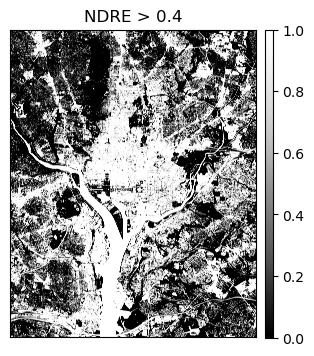

In [26]:
#############################################################
# Create a binary vegetation mask using a threshold on NDRE #
#############################################################

ndre = stack_mnf[0]
print(ndre)

# Get the veg summary stats
veg = pd.read_csv('dc_data_veg_sampled.csv')
print(veg['ndre'].describe())

# Create a mask of vegetation where NDRE > 0.4 (based on the vegetation samples)
veg_mask = np.where(ndre > 0.425480, 0, 1)
ep.plot_bands(veg_mask,figsize=(4,4),title=["NDRE > 0.4"])

del veg

(1, 7555, 6046)
(1, 7555, 6046)
Successfully exported array to 'dc_data_kmeans7.tif'


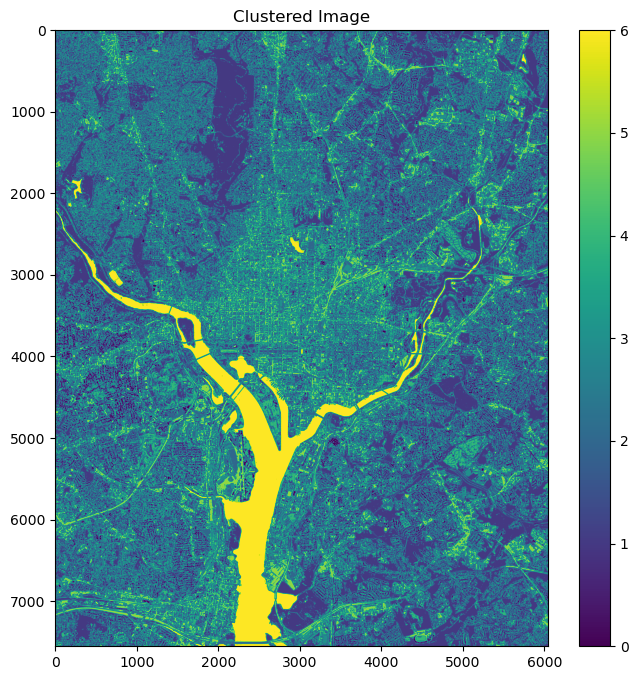

Time elapsed: 198.2 seconds.


In [37]:
############################################################
# Unsupervised classification of the MNF transformed image #
# To create a binary mask of water/veg & built-up          #
############################################################

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import io

start_time = time.time()

# Load the image
image = io.imread(mnf_path)

# Reshape the image data into a 2D array, where each row is a pixel and each column is a band
# The -1 in the reshape function infers the number of rows based on the other dimensions.
# bands = image.reshape(-1, image.shape[2])
bands = image[:, :, [0, 1, 2, 3, 4, 5, 6]].reshape(-1, 7)
# Optional: Standardize the features
scaler = StandardScaler()
bands_standardized = scaler.fit_transform(bands)
# Apply K-means clustering
n_clusters = 7  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(bands_standardized)

# Reshape the cluster assignments to match the original image shape
clustered_image_ = clusters.reshape(1, image.shape[0], image.shape[1])
print(clustered_image_.shape)
# Convert the array to a TIFF for export
out_kmeans_path = 'dc_data_kmeans7.tif'
out_kmeans = array_to_tif(clustered_image_.T, stack_mnf, out_kmeans_path, clip=False, shp=None)

# Visualize the clustered image
plt.figure(figsize=(8, 8))
plt.imshow(clusters.reshape(image.shape[0], image.shape[1]))
plt.title('Clustered Image')
plt.colorbar()
plt.show()

print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.") 

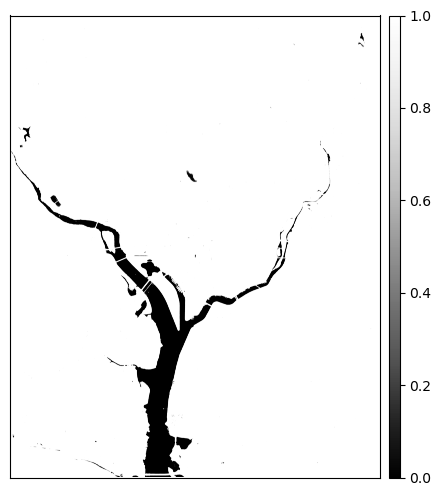

In [27]:
# Cluster 3 is water/shade. Create a water/shade mask
clustered_image_ = rxr.open_rasterio('dc_data_kmeans7.tif')
water_mask = np.where(clustered_image_ == 6, 0, 1)
ep.plot_bands(water_mask, figsize=(6,6))
del clustered_image_

In [28]:
# Grab projection information
# Get the WKT and GeoTransform
gdal.UseExceptions()  # Enable errors
try:
    ds = gdal.Open("dc_data_psscene13b_mnf_ind.tif")
    gt = ds.GetGeoTransform()
    wkt = ds.GetProjection()
except RuntimeError:  # <- Check first what exception is being thrown
    pass
del ds
print(f"GeoTransform: {gt}; \nWKT: {wkt}")

GeoTransform: (316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0); 
WKT: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [29]:
############################################
# Fully Constrained Least Squares Unmixing #
# Linear Spectral Mixture Analysis (LSMA)  #
# Single endmember per group               #
############################################

ems = ems  # results from PPI
stack_mnf_arr = np.asarray(stack_mnf)  # ensure that the MNF is a numpy array

import time
import traceback

num_processes = mp.cpu_count() - 1
print(f"Splitting across {num_processes} chunks for work ...")

# Check the data shapes
print(f"Image array (MNF) shape: {stack_mnf_arr.shape}; Endmember array shape: {ems.shape}")

# Split the MNF-transformed stack into chunks to be processed
chunks = np.array_split(stack_mnf_arr, num_processes, axis=2)

# Perform FCLS unmixing in parallel
start_time = time.time()
if __name__ == '__main__':
    
    # Function to parallelize FCLS unmixing
    def parallel_fcls_unmixing(chunk, endmembers):
        try:
            am = amap.FCLS()
            return am.map(chunk.T, endmembers, normalize=False)
        except Exception as e:
            traceback.print_exc()
            raise e
    
    with mp.Pool(processes=num_processes) as pool:
        try:
            unmix_results = pool.map(partial(parallel_fcls_unmixing, endmembers=ems), chunks)
            pool.close()
        except Exception as e:
            traceback.print_exc()
            raise e
        finally:
            pool.terminate()
            pool.join() 
            
print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.") 


Splitting across 31 chunks for work ...
Image array (MNF) shape: (7, 7555, 6046); Endmember array shape: (7, 7)


Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-9:
Process ForkPoolWorker-28:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-27:
Process ForkPoolWorker-10:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Process ForkPoolWorker-23:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-8:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-5:
Process ForkPoolWorker-18:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-19:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):

KeyboardInterrupt: 

In [49]:
# Retrieve the results
print(type(unmix_results))
print(len(unmix_results))
# Combine the FCLS results from all chunks back into a single array
ams_combined_parallel = np.concatenate(unmix_results)
print(f"Final combined array shape: {ams_combined_parallel.shape}")

<class 'list'>
31
Final combined array shape: (6046, 7555, 7)


In [50]:
print(gt, wkt)

(316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0) PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [52]:
# Export the abundance ndarray as a multiband raster
import xarray as xr

print(f"Original shape: {stack_mnf.shape}; \nAbundance maps shape: {ams_combined_parallel.shape}")
print(f"Length of 'y' attribute: {stack_mnf.y}; \nLength of shape[1]: {ams_combined_parallel.shape[1]}")

# Transpose the new array before exporting
in_arr = ams_combined_parallel.transpose(2, 1, 0)
print(in_arr.shape)

# Assign the correct coordinates for the transposed 'y' dimension
band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform
# out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_median.tif"
out_arr.rio.to_raster(output_path, compress='zstd', zstd_level=9,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")

Original shape: (7, 7555, 6046); 
Abundance maps shape: (6046, 7555, 7)
Length of 'y' attribute: <xarray.DataArray 'y' (y: 7555)>
array([4318294.5, 4318291.5, 4318288.5, ..., 4295638.5, 4295635.5, 4295632.5])
Coordinates:
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0; 
Length of shape[1]: 7555
(7, 7555, 6046)
Success !! ...


Class 0: ME
Class 1: CS
Class 2: SL
Class 3: UR
Class 4: WS
Class 5: SH
Class 6: TL


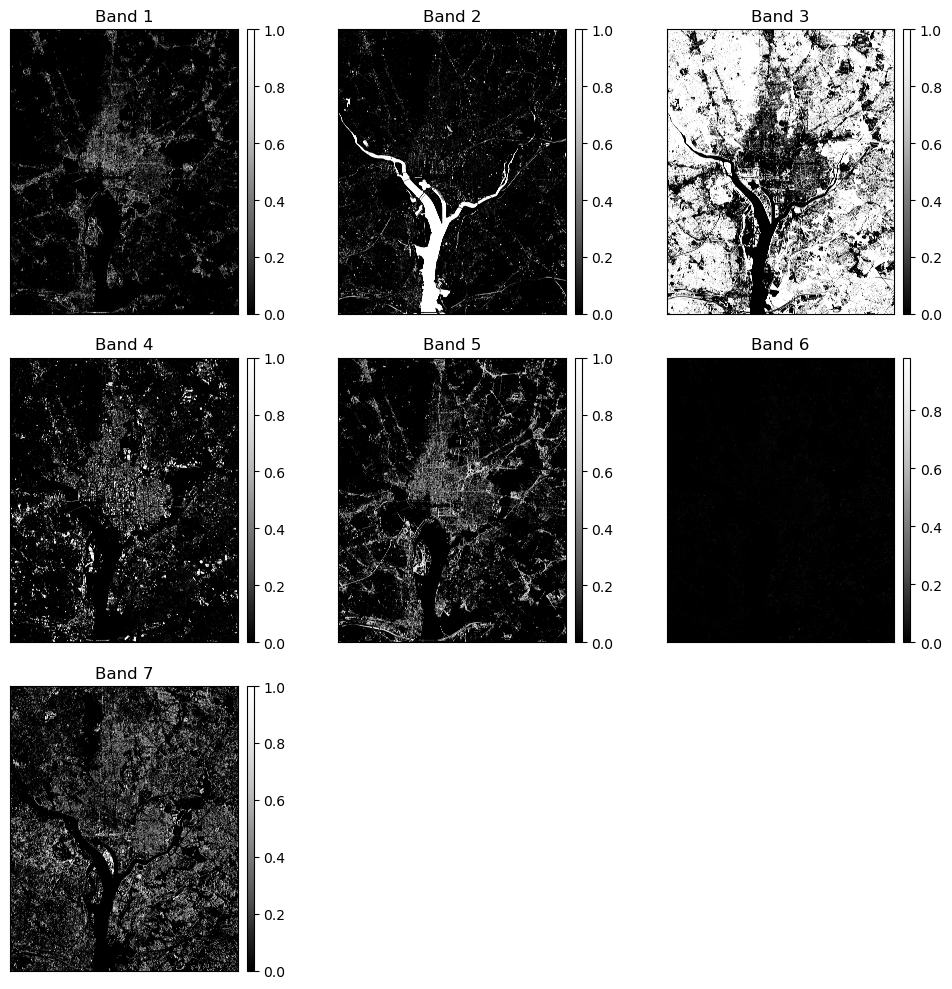

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [57]:
# Test the output by plotting the abundance maps
groups = ref_sp['class_code'].unique()
for i in range(len(groups)):
    print(f"Class {i}: {groups[i]}")
ep.plot_bands(
    ams_combined_parallel.T,
    scale=False,
    figsize=(10,10))

<class 'numpy.ndarray'>
(7, 7555, 6046)
(7, 7555, 6046)


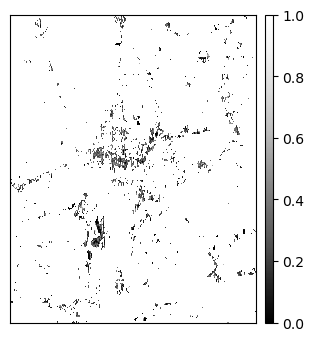

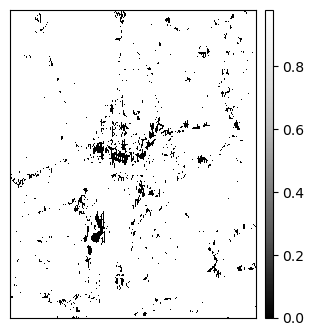

Success !! ...


In [61]:
# Create and export a masked version (masking out vegetation and water)

# Mask the MNF data using the veg/water & built-up mask

print(type(ams_combined_parallel.T))
print(ams_combined_parallel.T.shape)

mask = np.logical_xor(veg_mask, water_mask).astype(int)  # Convert boolean array to integer (1 or 0)

# Apply the combined mask to the original 7-band raster
ams_combined_parallel_masked = np.where(mask == 0, ams_combined_parallel.T, np.nan)  # Set to np.nan where the mask is 0

print(ams_combined_parallel_masked.shape)  # Should still be (7, 7555, 6046)

ep.plot_bands(ams_combined_parallel_masked[0],figsize=(4,4))
ep.plot_bands(ams_combined_parallel_masked[5],figsize=(4,4))

# Assign the correct coordinates for the transposed 'y' dimension

in_arr = ams_combined_parallel.T

band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr_ = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr_.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr_.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform
# out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_median_masked.tif"
out_arr_.rio.to_raster(output_path, compress='zstd', zstd_level=9,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")